In [1]:
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam
import numpy as np
# from agent.buffer import ReplayBuffer
from environment.fogg_behavioural_model import Patient 
import matplotlib.pyplot as plt

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13131373486674862393
]


In [3]:
def build_dqn(lr, n_actions, input_dims, fc1_dims,fc2_dims):
    model = Sequential([Dense(fc1_dims, input_shape = (input_dims,)), 
                       Activation('relu'),
                       Dense(fc2_dims),
                       Activation('relu'),
                       Dense(n_actions)])
    model.compile(optimizer=Adam(lr=lr), loss='mse')
    
    return model

In [4]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions, discrete=False):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.discrete = discrete
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        dtype = np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        # store one hot encoding of actions, if appropriate
        if self.discrete:
            actions = np.zeros(self.action_memory.shape[1])
            actions[action] = 1.0
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

In [5]:
class Agent(object):
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size, input_dims, epsilon_dec=0.996, epsilon_end = 0.01, mem_size=100000, fname='dgn.h5'):
        self.action_space = [i for i in range(n_actions)]
        self.n_actions = n_actions
        self.gamma = gamma
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions, discrete=True)
        self.batch_size = batch_size
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_end
        self.model_file = fname
        self.epsilon = epsilon
        
        self.q_eval = build_dqn(alpha, n_actions, input_dims, 32, 32)
        
    def remember(self, state, action, reward, new_state,done):
        self.memory.store_transition(state, action, reward, new_state, done)
    
    def choose_action(self, state):
        state = state[np.newaxis,:]
        rand = np.random.random()
        if rand < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            actions = self.q_eval.predict(state)
            action = np.argmax(actions)
        return action
    
    def learn(self):
        if self.memory.mem_cntr > self.batch_size:
            state, action, reward, new_state, done = \
                                          self.memory.sample_buffer(self.batch_size)

            action_values = np.array(self.action_space, dtype=np.int8)
            action_indices = np.dot(action, action_values)

            q_eval = self.q_eval.predict(state)

            q_next = self.q_eval.predict(new_state)

            q_target = q_eval.copy()

            batch_index = np.arange(self.batch_size, dtype=np.int32)

            q_target[batch_index, action_indices] = reward + \
                                  self.gamma*np.max(q_next, axis=1)*done

            _ = self.q_eval.fit(state, q_target, verbose=0)

            self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > \
                           self.epsilon_min else self.epsilon_min
        
    def save_model(self, i):
        name = 'dgn_CC_{0}.h5'.format(i)
        self.q_eval.save(name)
    
    def load_model(self):
        self.q_eval = load_model(self.model_file)
    

In [6]:
msh = []
x = []
y = []
eps_hist = []
for run in range(0, 10):
    env = Patient()
    env_info = {'behaviour_threshold': 20, 'has_family':True}
    env.env_init(env_info)
    agent = Agent(gamma = 0.99, epsilon=1.0, alpha = 0.005, input_dims = 13, n_actions= 2, mem_size= 100000, batch_size=32, epsilon_end = 0.01)
    observation = env.env_start()
    done = False
    score_history = []
    for j in range(0,90): # 3 months

        score = 0
        for i in range(0, 24):
            action = agent.choose_action(observation)
            reward, observation_,  info = env.step(action)
            agent.remember(observation, action, reward, observation_, done)
            
            x.append(observation)
            if reward == 10:
                y.append(1)
            elif reward == 11:
                y.append(2)
            else:
                y.append(0)
                
            score += reward
            observation = observation_
            agent.learn()

        score_history.append(score)
        eps_hist.append(agent.epsilon)
        avg_score = np.mean(score_history[-10:])
        print(score, avg_score)
    agent.save_model(run)
    msh.append(score_history)
  

-24.0 -24.0
-55.0 -39.5
-30.0 -36.333333333333336
-55.0 -41.0
-25.0 -37.8
-50.0 -39.833333333333336
-30.0 -38.42857142857143
-12.0 -35.125
-20.0 -33.44444444444444
7.0 -29.4
-10.0 -28.0
-3.0 -22.8
-2.0 -20.0
-2.0 -14.7
-13.0 -13.5
-30.0 -11.5
-35.0 -12.0
-10.0 -11.8
-3.0 -10.1
-3.0 -11.1
-36.0 -13.7
-2.0 -13.6
-22.0 -15.6
-16.0 -17.0
-7.0 -16.4
-4.0 -13.8
-3.0 -10.6
-1.0 -9.7
-2.0 -9.6
-1.0 -9.4
17.0 -4.1
-3.0 -4.2
0.0 -2.0
0.0 -0.4
-1.0 0.2
0.0 0.6
18.0 2.7
-8.0 2.0
-2.0 2.0
-1.0 2.0
0.0 0.3
-1.0 0.5
0.0 0.5
-1.0 0.4
8.0 1.3
-50.0 -3.7
-7.0 -6.2
0.0 -5.4
0.0 -5.2
-1.0 -5.2
18.0 -3.4
19.0 -1.4
-1.0 -1.5
0.0 -1.4
19.0 -0.3
0.0 4.7
0.0 5.4
20.0 7.4
20.0 9.4
-1.0 9.4
-1.0 7.5
20.0 7.6
18.0 9.5
0.0 9.5
20.0 9.6
20.0 11.6
-1.0 11.5
20.0 11.5
0.0 9.5
-2.0 9.4
-2.0 9.3
20.0 9.3
20.0 9.5
0.0 9.5
19.0 9.4
0.0 7.4
20.0 9.5
0.0 7.5
20.0 9.5
20.0 11.7
-2.0 11.7
-2.0 9.5
0.0 7.5
0.0 7.5
20.0 7.6
20.0 9.6
20.0 9.6
19.0 11.5
0.0 9.5
20.0 9.5
-18.0 -18.0
-50.0 -34.0
-65.0 -44.333333333333336
-45.0 -44

KeyboardInterrupt: 

In [8]:
len(msh)

9

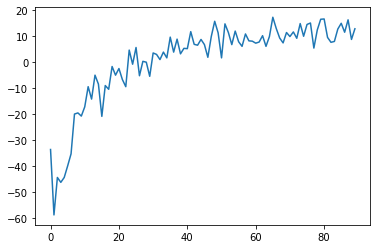

In [9]:
plt.plot(np.mean(msh, axis=0))